## Regression network on engineered features

- **Train the regression models on muons only**  
- **Test on testing portion of muons and all pions**  
- **No selection on momentum range**  
- **Only the in-time hits where delta <= 0.5 are included**

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import pyarrow as pa
import polars as pl
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
import tqdm
from torchsummary import summary
import seaborn as sns
import matplotlib.pyplot as plt
from helpers import mean_std_cross_val_scores

- **Regressors (Engineered features used for the models):**
    - `total_in_time_hits`: total number of in-time hits in each event 
    - `x_aligned_min`: minimum hit position realigned by subtracting track position x in each event
    - `x_aligned_max`: maximum hit position realigned by subtracting track position x in each event
    - `y_aligned_min`: minimum hit position realigned by subtracting track position y in each event
    - `y_aligned_max`: maximum hit position realigned by subtracting track position y in each event
    - `x_aligned_width`: maximum hit position x minus minimum hit position x in each event
    - `y_aligned_witdh`: maximum hit position y minus minimum hit position y in each event `
    - `hit_distance_min`: minimum distance between hit position and track position in each event 
    - `hit_distance_max`: maximum distance between hit position and track position in each event 
    - `hit_distance_mean`: mean distance between hit position and track position in each event 
    - `hit_distance_median`: median distance between hit position and track position in each event
    - `hit_distance_q25`: 25% percentile distance between hit position and track position in each event
    - `hit_distance_q75`: 75% percentile distance between hit position and track position in each event
    - `hit_distance_rms`: root mean squared distance between hit position and track position in each event 
    - `hull_area`: hull area of the convex hull
    - `hull_diameter`: the longest line among all the points
    - `hull_diff_width_diameter`: the absolute difference between `hull_diameter` and `hull_width`
    - `hull_width`: closest distance of the parallel lines that encloses all points  

- **Target:**
    - `ring_radius_cal`: calculated ring radius based on the particle mass and track momentum

### 1.0 Read and process data

In [2]:
event_with_hit_features_path = 'data/events_with_hit_features_[cut_off_time=0.5].parquet'

In [3]:
df = pl.read_parquet(event_with_hit_features_path
                    ).drop_nulls()

In [4]:
df.shape

(2374977, 42)

In [5]:
# remove events with ring_radius_cal == NaN
# Polars allows NaN for float columns. 
# These NaN values are considered to be a type of floating point data rather than missing data (Null)
# https://pola-rs.github.io/polars-book/user-guide/expressions/null/#fill-with-interpolation
df = df.filter(pl.col('ring_radius_cal').is_not_nan())

In [6]:
df.shape

(2374295, 42)

In [7]:
# select data for muon only(label as 0)
df_muon = df.filter(pl.col('label')==0)

In [8]:
df_muon.shape

(2158648, 42)

In [9]:
# check min of ring_radius_cal
df_muon.select('ring_radius_cal').min()

ring_radius_cal
f32
8.215014


In [10]:
train_df, test_df = train_test_split(df_muon, 
                                     test_size=0.2,
                                     random_state=42,
                                     shuffle=True)

In [11]:
X_train_raw, y_train = train_df.select(['total_in_time_hits','x_aligned_min', 'x_aligned_max', 'x_aligned_width',
            'y_aligned_min', 'y_aligned_max', 'y_aligned_width',
            'hit_distance_min', 'hit_distance_max', 'hit_distance_mean', 'hit_distance_median',
            'hit_distance_q25', 'hit_distance_q75', 'hit_distance_rms',
            'hull_area', 'hull_diameter', 'hull_diff_width_diameter', 'hull_width']
                                  ), train_df.select('ring_radius_cal')

In [12]:
X_test_raw, y_test = test_df.select(['total_in_time_hits','x_aligned_min', 'x_aligned_max', 'x_aligned_width',
            'y_aligned_min', 'y_aligned_max', 'y_aligned_width',
            'hit_distance_min', 'hit_distance_max', 'hit_distance_mean', 'hit_distance_median',
            'hit_distance_q25', 'hit_distance_q75', 'hit_distance_rms',
            'hull_area', 'hull_diameter', 'hull_diff_width_diameter', 'hull_width']
                                  ), test_df.select('ring_radius_cal')

In [13]:
# Standardizing data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

### 2.0 Baseline sklearn LinearRegression

In [14]:
regression_metrics = ["r2", "neg_mean_absolute_error", "neg_median_absolute_error"]

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
model_lr = LinearRegression()

In [17]:
%%time
model_lr.fit(X_train, y_train)

CPU times: user 674 ms, sys: 123 ms, total: 798 ms
Wall time: 539 ms


LinearRegression()

In [18]:
results = {}

results['LinearRegression'] = mean_std_cross_val_scores(
    model_lr, 
    X_train, 
    y_train, 
    return_train_score=True, 
    scoring=regression_metrics)

In [19]:
model_lr.score(X_test, y_test)

0.8526309371040279

In [20]:
mean_absolute_error(y_test, model_lr.predict(X_test))

2.3165054187013925

### 3.0 Baseline XGBRegressor

In [21]:
import xgboost as xgb
from xgboost import XGBRegressor

In [22]:
xgb_reg = xgb.XGBRegressor()

In [23]:
%%time
xgb_reg.fit(X_train, y_train)

CPU times: user 9min 21s, sys: 34.3 s, total: 9min 55s
Wall time: 1min 17s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [24]:
results['XGBRegressor'] = mean_std_cross_val_scores(
    xgb_reg, 
    X_train, 
    y_train, 
    return_train_score=True, 
    scoring=regression_metrics)

results_df = pd.DataFrame(results).T
results_df

,fit_time,score_time,test_r2,train_r2,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_median_absolute_error,train_neg_median_absolute_error
LinearRegression,0.438 (+/- 0.010),0.009 (+/- 0.000),0.855 (+/- 0.007),0.855 (+/- 0.002),-2.316 (+/- 0.004),-2.316 (+/- 0.006),-1.621 (+/- 0.003),-1.621 (+/- 0.002)
XGBRegressor,64.397 (+/- 3.383),0.096 (+/- 0.004),0.945 (+/- 0.001),0.962 (+/- 0.000),-1.590 (+/- 0.003),-1.542 (+/- 0.001),-1.171 (+/- 0.003),-1.165 (+/- 0.001)


In [25]:
%%time
xgb_reg.score(X_test, y_test)

CPU times: user 881 ms, sys: 31.2 ms, total: 912 ms
Wall time: 126 ms


0.943048174983375

In [26]:
y_test_pred_xgb = xgb_reg.predict(X_test)

In [27]:
mean_absolute_error(y_test, y_test_pred_xgb)

1.5911542

### 4.0 Non-linear Regression NN

In [28]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy().flatten(), dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy().flatten(), dtype=torch.float32)

In [29]:
trainset = TensorDataset(X_train, y_train)

In [30]:
# split trainset to train and validation
train_size = int(0.6 * len(trainset)) # 60% of train data
val_size = len(trainset) - train_size

generator1 = torch.Generator().manual_seed(42)
train_set, val_set = random_split(dataset=trainset, 
                                  lengths=[train_size, val_size],
                                  generator=generator1)

In [31]:
BATCH_SIZE = 1000 # adjust batch size later
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

In [32]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [33]:
# below code adopted from MDS DSCI 572 Lecture 5 notes
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, patience=5, verbose=True):
    """Training wrapper for PyTorch network."""
    
    train_loss = []
    valid_loss = []
    
    for epoch in range(epochs):
        train_batch_loss = 0
        valid_batch_loss = 0
        
        # Training
        for X, y in trainloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()       # Clear gradients w.r.t. parameters
            y_hat = model(X).flatten()  # Forward pass to get output
            loss = criterion(y_hat, y)  # Calculate loss
            loss.backward()             # Getting gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            train_batch_loss += loss.item()       # Add loss for this batch to running total
            
        train_loss.append(train_batch_loss / len(trainloader))
            
        # Validation
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood

            for X_valid, y_valid in validloader:
                X_valid, y_valid = X_valid.to(device), y_valid.to(device)
                y_hat = model(X_valid).flatten()  # Forward pass to get output
                loss = criterion(y_hat, y_valid)  # Calculate loss based on output

                valid_batch_loss += loss.item()
            
        valid_loss.append(valid_batch_loss / len(validloader))

        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1:3}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.")
        
        # Early stopping
        if epoch > 0 and valid_loss[-1] > valid_loss[-2]:
            consec_increases += 1
        else:
            consec_increases = 0
        if consec_increases == patience:
            print(f"Stopped early at epoch {epoch + 1} - val loss increased for {consec_increases} consecutive epochs!")
            break
            
    return train_loss, valid_loss

In [34]:
# Define the model
model = torch.nn.Sequential(
    nn.Linear(18, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 12),
    nn.ReLU(),
    nn.Linear(12, 1)
)
model.to(device)

Sequential(
  (0): Linear(in_features=18, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=64, bias=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=12, bias=True)
  (9): ReLU()
  (10): Linear(in_features=12, out_features=1, bias=True)
)

In [35]:
# print(model)

In [36]:
# summary(model)

In [37]:
# model.state_dict()

In [38]:
LEARNING_RATE = 0.0001
criterion = nn.MSELoss() # loss function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [39]:
%%time
train_loss, valid_loss = trainer(model, 
                                 criterion, 
                                 optimizer, 
                                 trainloader,
                                 validloader,
                                 epochs=30, 
                                 patience=5,
                                 verbose=True)

Epoch   1: Train Loss: 4569.011. Valid Loss: 40.627.
Epoch   2: Train Loss: 19.898. Valid Loss: 13.590.
Epoch   3: Train Loss: 12.436. Valid Loss: 11.076.
Epoch   4: Train Loss: 10.782. Valid Loss: 9.996.
Epoch   5: Train Loss: 10.061. Valid Loss: 9.666.
Epoch   6: Train Loss: 9.614. Valid Loss: 9.139.
Epoch   7: Train Loss: 9.248. Valid Loss: 8.984.
Epoch   8: Train Loss: 9.079. Valid Loss: 8.727.
Epoch   9: Train Loss: 8.885. Valid Loss: 9.851.
Epoch  10: Train Loss: 8.738. Valid Loss: 8.615.
Epoch  11: Train Loss: 8.540. Valid Loss: 8.364.
Epoch  12: Train Loss: 8.441. Valid Loss: 8.489.
Epoch  13: Train Loss: 8.304. Valid Loss: 8.486.
Epoch  14: Train Loss: 8.248. Valid Loss: 8.223.
Epoch  15: Train Loss: 8.142. Valid Loss: 7.995.
Epoch  16: Train Loss: 8.085. Valid Loss: 8.390.
Epoch  17: Train Loss: 8.043. Valid Loss: 7.965.
Epoch  18: Train Loss: 7.967. Valid Loss: 8.013.
Epoch  19: Train Loss: 7.892. Valid Loss: 8.036.
Epoch  20: Train Loss: 7.846. Valid Loss: 7.861.
Epoch  21:

### 5.0 Prediction performance on test df of muons

In [40]:
# notice that tensor on mps cannot be converted to numpy directly so using to('cpu')
y_test_pred_nn = model(X_test.to(device)).detach().to('cpu').numpy().squeeze()

In [41]:
y_test_pred_nn

array([183.85925, 184.42392, 178.73306, ..., 185.21399, 186.1763 ,
       151.03065], dtype=float32)

In [42]:
r2_score(y_test, y_test_pred_nn)

0.9391525252942783

In [43]:
mean_absolute_error(y_test, y_test_pred_nn)

1.7407391

In [44]:
test_pred_df = pd.DataFrame(y_test_pred_nn, y_test.numpy()).reset_index()
test_pred_df.columns=['theoretical_radius', 'predicted_radius_nn']

In [45]:
test_pred_df['residual_nn'] = test_pred_df['theoretical_radius'] - test_pred_df['predicted_radius_nn']

In [46]:
test_pred_df['predicted_radius_xgb'] = y_test_pred_xgb
test_pred_df['residual_xgb'] = test_pred_df['theoretical_radius'] - test_pred_df['predicted_radius_xgb']

Text(0, 0.5, 'Residual_nn')

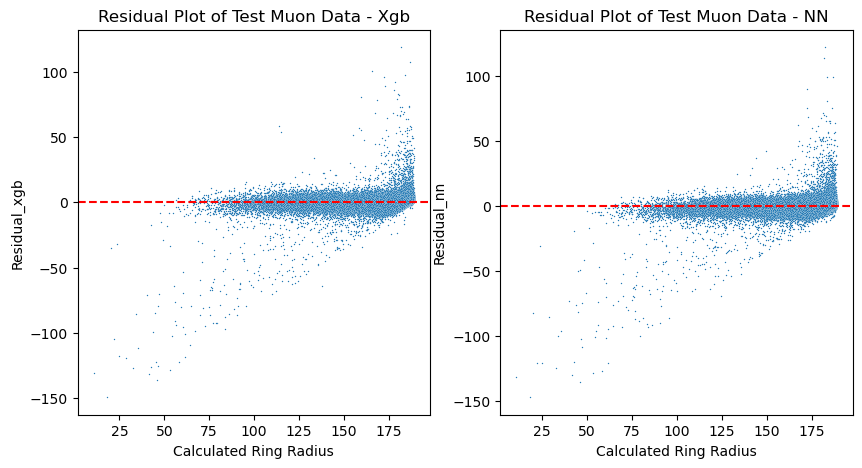

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(data=test_pred_df, x='theoretical_radius', y='residual_xgb', s=1, ax=axes[0])
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_title('Residual Plot of Test Muon Data - Xgb')
axes[0].set_xlabel('Calculated Ring Radius')
axes[0].set_ylabel('Residual_xgb')

sns.scatterplot(data=test_pred_df, x='theoretical_radius', y='residual_nn', s=1, ax=axes[1])
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_title('Residual Plot of Test Muon Data - NN')
axes[1].set_xlabel('Calculated Ring Radius')
axes[1].set_ylabel('Residual_nn')

In [48]:
test_pred_df

,theoretical_radius,predicted_radius_nn,residual_nn,predicted_radius_xgb,residual_xgb
0,185.335312,183.859253,1.476059,184.743744,0.591568
1,184.767960,184.423920,0.344040,183.701691,1.066269
2,182.299835,178.733063,3.566772,180.004517,2.295319
3,187.461014,185.289948,2.171066,184.825684,2.635330
4,181.856476,184.295532,-2.439056,183.638489,-1.782013
...,...,...,...,...,...
431725,185.604385,185.017273,0.587112,186.219177,-0.614792
431726,186.997299,185.962982,1.034317,185.676926,1.320374
431727,185.636093,185.213989,0.422104,184.815903,0.820190
431728,186.802338,186.176300,0.626038,186.923920,-0.121582


In [49]:
test_pred_df.describe()

,theoretical_radius,predicted_radius_nn,residual_nn,predicted_radius_xgb,residual_xgb
count,431730.000000,431730.000000,431730.000000,431730.000000,431730.000000
mean,180.515088,180.319977,0.195108,180.507706,0.007366
std,11.487627,11.005298,2.826960,11.200941,2.741464
min,10.650927,53.574375,-147.278749,51.898735,-149.287554
25%,179.534912,179.783096,-1.032696,179.942970,-1.124920
50%,184.089706,183.857300,0.345413,184.188164,0.140709
75%,186.563194,185.845303,1.533646,186.169125,1.205669
max,188.997330,196.124100,121.993336,203.642456,118.630569


### 6.0 Prediction performance on pion data

In [50]:
df_pion = df.filter(pl.col('label')==1)
df_pion.shape

(215647, 42)

In [51]:
X_pion, y_pion = df_pion.select(['total_in_time_hits','x_aligned_min', 'x_aligned_max', 'x_aligned_width',
            'y_aligned_min', 'y_aligned_max', 'y_aligned_width',
            'hit_distance_min', 'hit_distance_max', 'hit_distance_mean', 'hit_distance_median',
            'hit_distance_q25', 'hit_distance_q75', 'hit_distance_rms',
            'hull_area', 'hull_diameter', 'hull_diff_width_diameter', 'hull_width']
                               ), df_pion.select('ring_radius_cal')

In [52]:
X_pion = scaler.transform(X_pion)

**Prediction by Xgb**

In [53]:
xgb_reg.score(X_pion, y_pion)

0.9055521787616003

In [54]:
y_pion_pred_xgb = xgb_reg.predict(X_pion)

# double check r2 score
r2_score(y_pion, y_pion_pred_xgb)

0.9055521787616003

In [55]:
mean_absolute_error(y_pion, y_pion_pred_xgb)

2.3741896

**Prediction by NN**

In [56]:
X_pion_nn = torch.tensor(X_pion, dtype=torch.float32)
y_pion_nn = torch.tensor(y_pion.to_numpy().flatten(), dtype=torch.float32)

y_pion_pred_nn = model(X_pion_nn.to(device)).detach().to('cpu').numpy().squeeze()

In [57]:
r2_score(y_pion, y_pion_pred_nn)

0.9122690650548687

In [58]:
mean_absolute_error(y_pion, y_pion_pred_nn)

2.3650622

In [59]:
pion_pred_df = pd.DataFrame(y_pion_pred_nn, y_pion_nn.numpy()).reset_index()
pion_pred_df.columns=['theoretical_radius', 'predicted_radius_nn']

pion_pred_df['residual_nn'] = pion_pred_df['theoretical_radius'] - pion_pred_df['predicted_radius_nn']

pion_pred_df['predicted_radius_xgb'] = y_pion_pred_xgb
pion_pred_df['residual_xgb'] = pion_pred_df['theoretical_radius'] - pion_pred_df['predicted_radius_xgb']

Text(0, 0.5, 'Residual_nn')

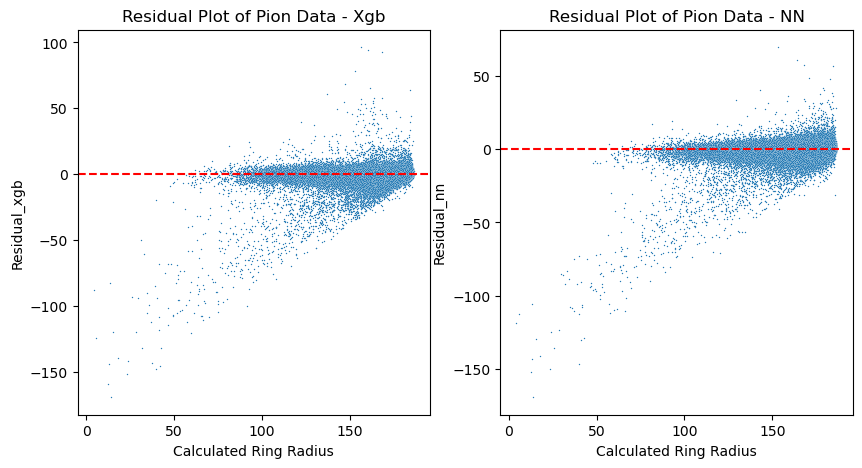

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(data=pion_pred_df, x='theoretical_radius', y='residual_xgb', s=1, ax=axes[0])
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_title('Residual Plot of Pion Data - Xgb')
axes[0].set_xlabel('Calculated Ring Radius')
axes[0].set_ylabel('Residual_xgb')

sns.scatterplot(data=pion_pred_df, x='theoretical_radius', y='residual_nn', s=1, ax=axes[1])
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_title('Residual Plot of Pion Data - NN')
axes[1].set_xlabel('Calculated Ring Radius')
axes[1].set_ylabel('Residual_nn')

In [61]:
pion_pred_df.describe()

,theoretical_radius,predicted_radius_nn,residual_nn,predicted_radius_xgb,residual_xgb
count,215647.000000,215647.000000,215647.000000,215647.000000,215647.000000
mean,171.302222,172.150406,-0.848193,172.319153,-1.016938
std,14.426835,13.904529,4.188116,14.226271,4.315506
min,4.270976,53.587410,-169.054245,55.723156,-169.210510
25%,167.550240,168.013466,-2.309280,168.199745,-2.419968
50%,175.736923,176.301849,-0.647522,176.626862,-0.854034
75%,180.495514,181.206703,0.991852,181.578987,0.763062
max,186.676727,216.761612,69.318703,196.356598,96.338921
